## one method one figure

In [73]:
import numpy as np
from stdb import load_db 
import pygmt
import pandas as pd
import pickle
import glob, os
import warnings  
from obspy.core.event.catalog import read_events
from obspy.geodetics.base import gps2dist_azimuth
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")  

In [37]:
pygmt.config(FONT_ANNOT_PRIMARY = '10p,Times-Roman',
            FONT_LABEL = '8',
            MAP_LABEL_OFFSET = '4p',
            MAP_TICK_LENGTH_PRIMARY = '5p',
#             PS_MEDIA ='A4',
            PROJ_LENGTH_UNIT = 'c',
            MAP_ANNOT_OFFSET_PRIMARY = '5p',
            MAP_ANNOT_OFFSET_SECONDARY = '5p',
            MAP_FRAME_TYPE = 'fancy',
            MAP_FRAME_WIDTH = 'auto',
            FORMAT_GEO_MAP = 'D',
            PS_CHAR_ENCODING = 'Standard+',
            MAP_FRAME_PEN = '2p,black')

def find_color(percent):
    if percent <=10: color = '255/255/204'
    elif 10<percent <=20: color = '255/255/102'
    elif 20<percent <=30: color = 'yellow'
    elif 30<percent <=40: color = '255/187/0'
    elif 40<percent <=50: color = '255/119/0'
    elif 50<percent <=60: color = '255/51/0'
    elif 60<percent <=70: color = 'red'
    elif 70<percent <=80: color = 'red2'
    elif 80<percent <=90: color = 'red3'
    elif 90<percent:      color = 'red4'
    return color
def PygmtBegin(figmap, region):
#     grid = pygmt.datasets.load_earth_relief(resolution="30s", region=region)
    pygmt.makecpt(cmap="elevation", series=[0, 4000, 500],output = 'eleva.cpt', continuous=True)
    figmap.basemap(region=region, projection="M15c", frame = ['x1f0.5', 'y1f0.5', 'nSeW'])
    figmap.grdimage('@earth_relief_30s',region =region, cmap="eleva.cpt",monochrome=True, shading=True, transparency=50)
    figmap.coast(resolution = 'h', shorelines ='1/thinnest,black', water='white', borders = '1/0.25p')
# ##==========legned setting 
#     figmap.plot(x=40.5,y=39.1,style="c0.5c", pen="black", no_clip=True)
#     figmap.text(x=40.5,y=38.9,text='Null', font="12p,Times-Bold,black", no_clip=True)
#     RCdata = [[41.5, 39.1, 0, 5, 1*40]]
#     SCdata = [[41.5, 38.9, 0, 5, 1*40]]
#     figmap.plot(data=RCdata, style="J", color="deepskyblue1", pen="0.01p,black", no_clip=True)
#     figmap.text(x=42,y=39.1,text='RC', font="12p,Times-Bold,black", no_clip=True)
#     figmap.plot(data=SCdata, style="J", color="red3", pen="0.01p,black", no_clip=True)
#     figmap.text(x=42,y=38.9,text='SC', font="12p,Times-Bold,black", no_clip=True)
#     legenddata=[[43, 39.1, 0, 5, 0.5*40],[43.8, 39.1, 0, 5, 1*40],[44.8, 39.1, 0, 5, 1.5*40]]
#     figmap.plot(data=legenddata, style="J", color="black", pen="0.01p,black", no_clip=True)
#     figmap.text(x=43,y=38.9,text='0.5s', font="12p,Times-Bold,black", no_clip=True)
#     figmap.text(x=43.8,y=38.9,text='1s', font="12p,Times-Bold,black", no_clip=True)
#     figmap.text(x=44.8,y=38.9,text='1.5s', font="12p,Times-Bold,black", no_clip=True)
    

In [40]:
PKLpath = '/Volumes/home/Research/STEP/01_Split'
Path = '/Volumes/home/Research/STEP/05_Station_result_statistics'
indpath = '/Volumes/home/Research/STEP/02_Station_result_csv'
SAVEpath = '/Volumes/home/Research/STEP/06_CIA_SWS_result/2010-2020_SKS_SKKS'

YearRange = '2010-2020'
csvfile = f'Station_SK(K)S_{YearRange}average_v5.csv'
ver=2

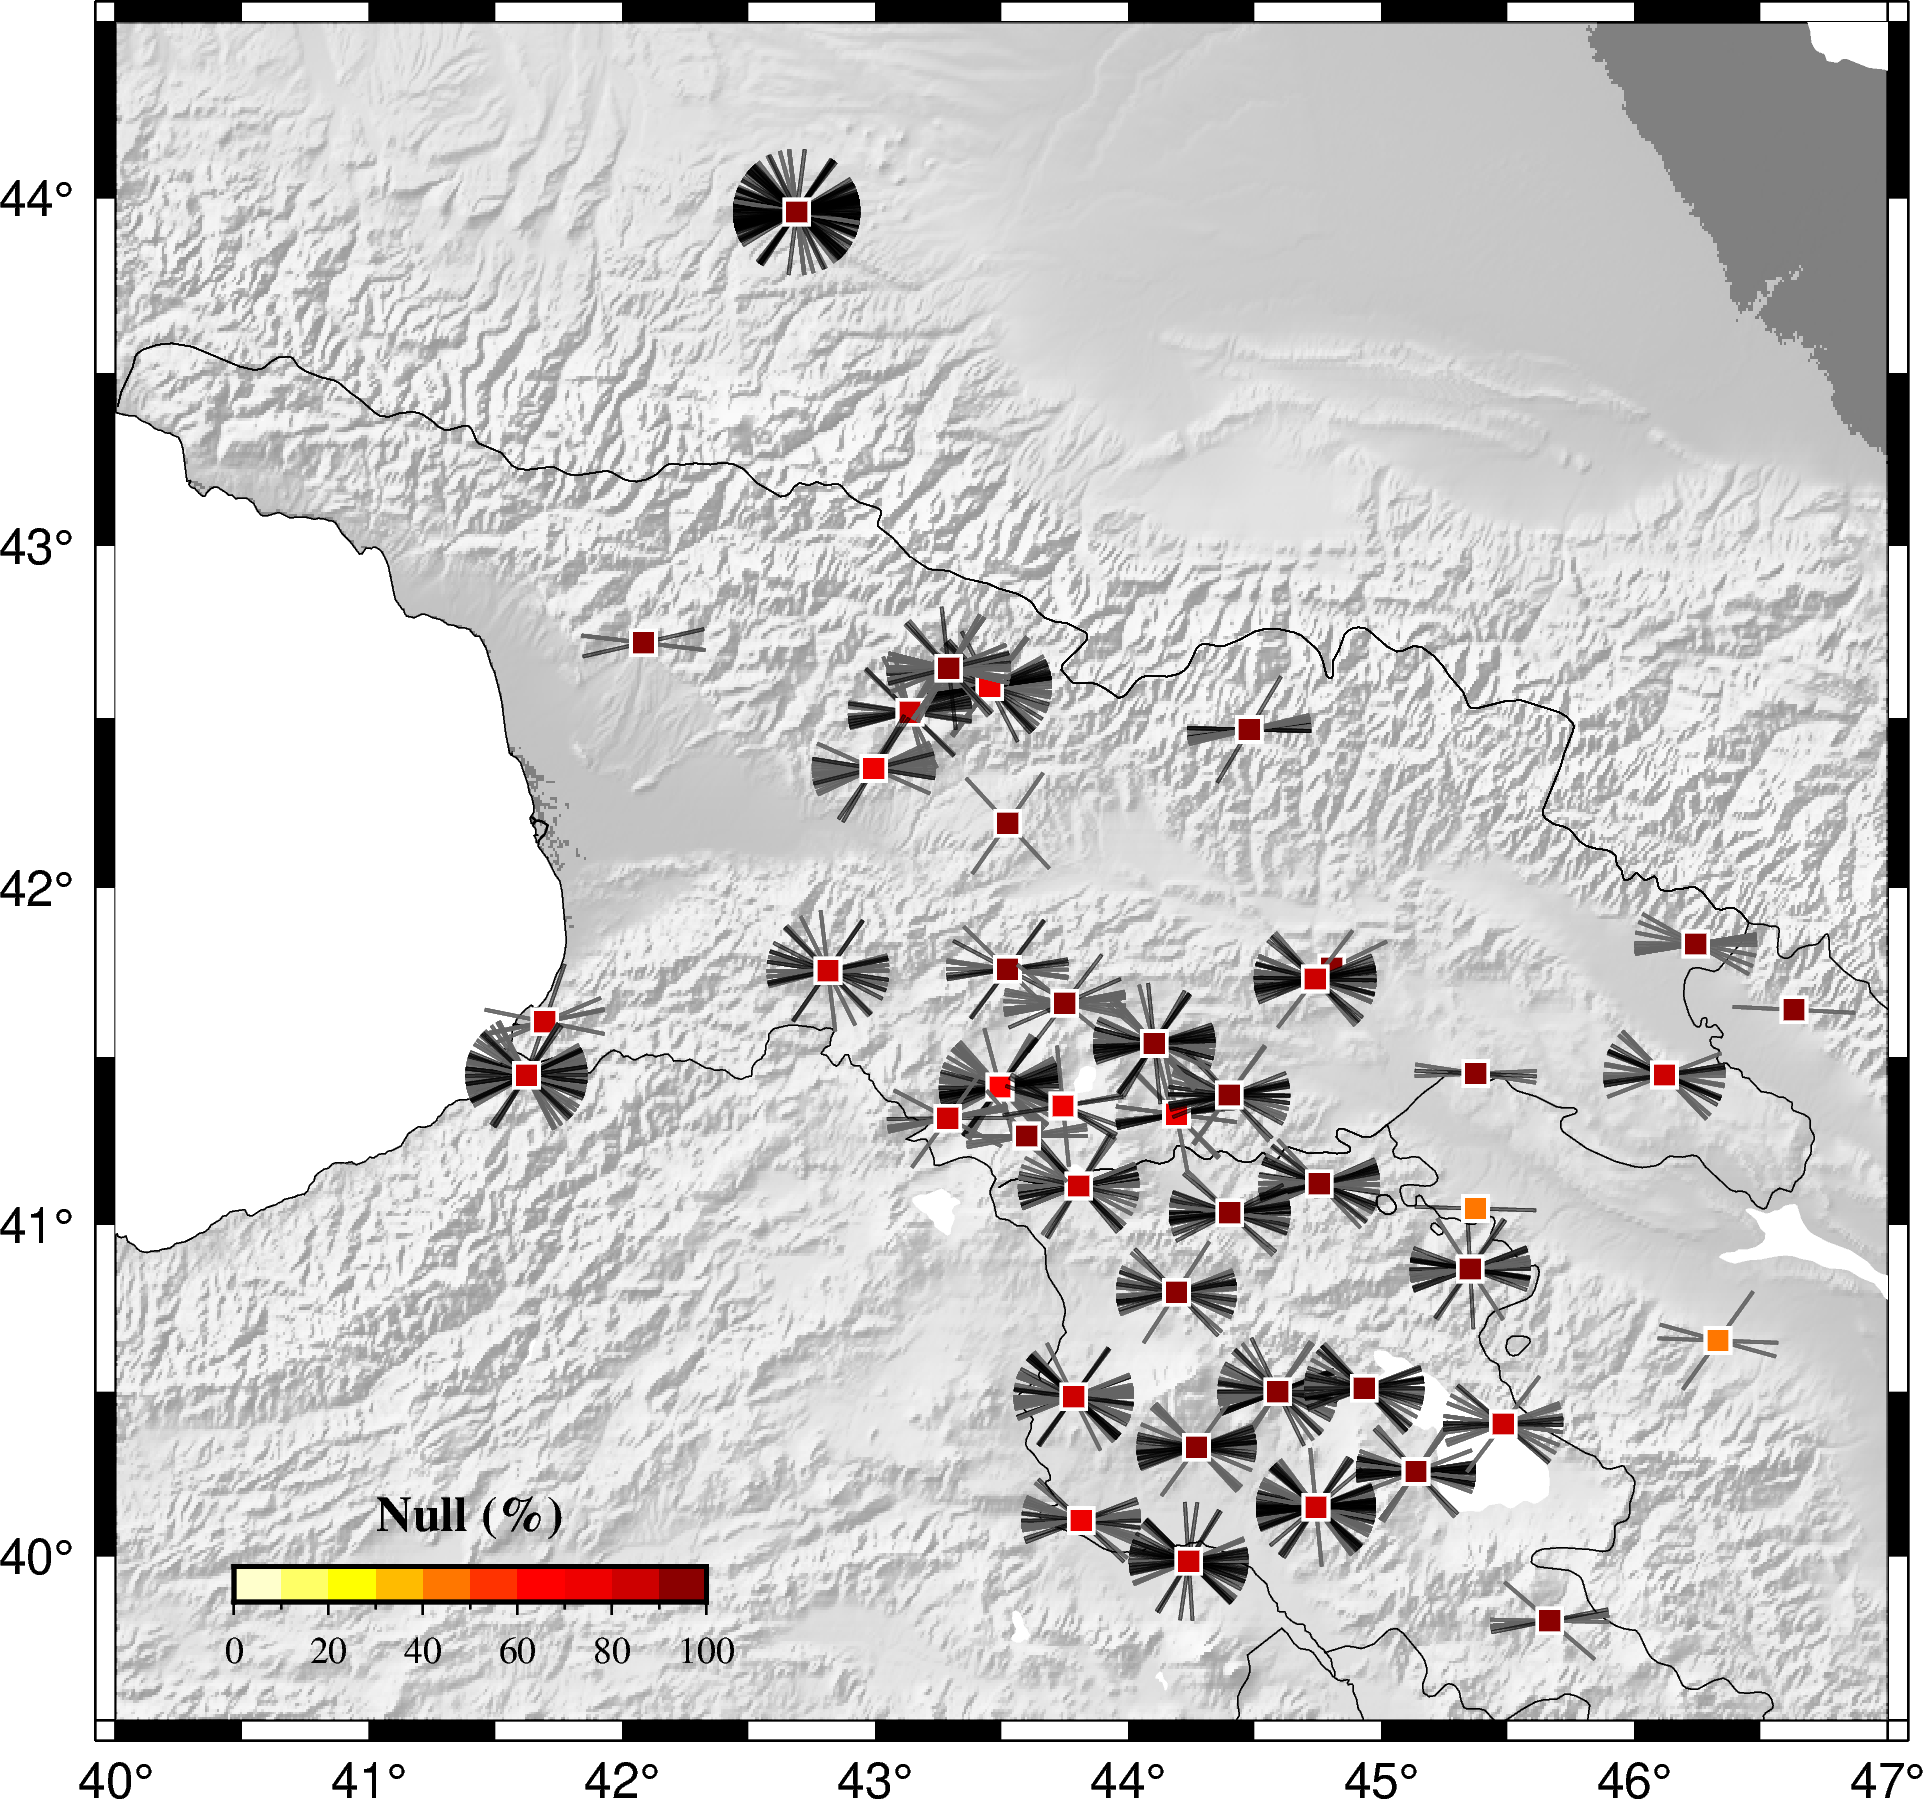

In [64]:
##==================for Null condition 

regvals = [40, 47, 39.5, 44.5]
figmap = pygmt.Figure()
PygmtBegin(figmap, regvals)
df = pd.read_csv(f'{Path}/{csvfile}')
for STApath in glob.glob(f'{PKLpath}/*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    NET = values['network']; STA = values['station']
    st_lat = values['latitude']; st_lon = values['longitude']
    netsta = f'{NET}.{STA}'
    
    if NET != 'XG':
        
        for indcsv in glob.glob(f'{indpath}/2010-2020_*_classify/{NET}.{STA}_split_result.csv'):
            dff = pd.read_csv(indcsv)
            dff_null = dff[dff['Pick']==True][dff['Null']==True]
            dff_null = dff_null.sort_values(by=['CpH'], ascending=True)
            for j in range(len(dff_null)):
                evlat = dff_null['Ev_lat'].values[j]
                evlon = dff_null['Ev_lon'].values[j]     
                CpH   = dff_null['CpH'].values[j]
                dist, az, baz = gps2dist_azimuth(evlat,evlon,st_lat,st_lon)
                if CpH >=0.9:
                    bazcolor = 'black'; bazt=50
                else: bazcolor = '100'; bazt=10
                    
                bazdata = [[st_lon, st_lat, baz-90, 1, 1*40]]
                figmap.plot(data=bazdata, style="J", color=bazcolor, pen=f"0.01p,{bazcolor}",transparency=bazt)
        df_sta = df[df['Station']==netsta]
        nonnull = df_sta['nonNull'].values[0]
        null = df_sta['Null'].values[0]
        total = nonnull + null
        percent = (null / total) * 100
        color = find_color(percent)     
        figmap.plot(x=st_lon, y=st_lat, style = 's0.3c', color = color,  pen="0.8p,white"  )
        
with pygmt.config(FONT_ANNOT_PRIMARY = '9p,Times-Roman', FONT_LABEL = '12p,5',
                  MAP_ANNOT_OFFSET_PRIMARY = '0.2c', MAP_LABEL_OFFSET = '0.3c', 
                  MAP_TICK_LENGTH_PRIMARY = '0.1c', MAP_FRAME_PEN = '1p'):          
    figmap.colorbar(position='x1c/1c+w4c/0.3c+h+ml',frame='af+l"Null (%)"', cmap = 'NullPercent.cpt')
figmap.show()
figmap.savefig(f'{SAVEpath}/03_null_percent.png',dpi=200)
figmap.savefig(f'{SAVEpath}/03_null_percent.pdf')

In [66]:
bazdf = {'net':[],
     'station':[],
         'baz':[],
         'CpH':[]}
for STApath in glob.glob(f'{PKLpath}/*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    NET = values['network']; STA = values['station']
    st_lat = values['latitude']; st_lon = values['longitude']
    netsta = f'{NET}.{STA}'
    
    if NET != 'XG':
        for indcsv in glob.glob(f'{indpath}/2010-2020_*_classify/{NET}.{STA}_split_result.csv'):
            dff = pd.read_csv(indcsv)
            dff_null = dff[dff['Pick']==True][dff['Null']==True]
            dff_null = dff_null.sort_values(by=['CpH'], ascending=True)
            for j in range(len(dff_null)):
                evlat = dff_null['Ev_lat'].values[j]
                evlon = dff_null['Ev_lon'].values[j]     
                CpH   = dff_null['CpH'].values[j]
                dist, az, baz = gps2dist_azimuth(evlat,evlon,st_lat,st_lon)
                bazdf['net'].append(NET)
                bazdf['station'].append(STA)
                bazdf['baz'].append(baz)
                bazdf['CpH'].append(CpH)

In [68]:
bazdf = pd.DataFrame(bazdf)

In [107]:
bazdf_cph  = bazdf[bazdf['CpH']>=0.9]
bazdf_cph_ = bazdf[bazdf['CpH']<0.9]

In [174]:
binRange = np.arange(0,361,20)
hist1,_ = np.histogram(bazdf_cph['baz'], bins=binRange)
hist2,_ = np.histogram(bazdf_cph_['baz'], bins=binRange)
x = np.arange(0,360,20)

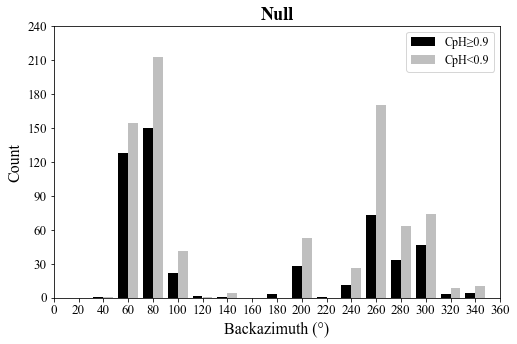

In [181]:
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(8,5))
plt.bar(x-4,hist1, color='k', width = 8, align='center', label='CpH≥0.9') 
plt.bar(x+4,hist2, alpha = 0.5, color='gray', width = 8, align='center',label='CpH<0.9') 
plt.xticks(range(0,361,20),fontsize=13)
plt.yticks(range(0,250,30),fontsize=13)
plt.xlim(0,360)
plt.xlabel('Backazimuth (°)',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.legend(fontsize=12)
plt.title('Null',fontsize=18, fontweight='bold')
plt.savefig(f'{SAVEpath}/04_BazNull_dist.png',dpi=200)
plt.savefig(f'{SAVEpath}/04_BazNull_dist.pdf')